### Import Libraries 

In [144]:
import pandas as pd
import numpy as np
import tqdm
import nltk
import time
import random
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from operator import itemgetter
from PIL import Image

In [145]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
import keras as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

### Load Dataset

In [147]:
df = pd.read_csv('messages.csv')
df.head()
df_orig = df.copy()

In [148]:
df.shape


(5572, 2)

In [149]:
pd.set_option('display.max_colwidth', None)

print(df_orig.head(15))

   Category  \
0       ham   
1       ham   
2      spam   
3       ham   
4       ham   
5      spam   
6       ham   
7       ham   
8      spam   
9      spam   
10      ham   
11     spam   
12     spam   
13      ham   
14      ham   

                                                                                                                                                                                                 Message  
0                                                                                        Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                                                          Ok lar... Joking wif u oni...  
2                                            Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry que

## Data Cleaning

In [150]:
df_orig.drop_duplicates(subset=['Message'], keep='first', inplace=True)

In [151]:
df_orig.shape

(5157, 2)

In [152]:
df_orig.value_counts('Category', normalize=True)*100

Category
ham     87.570293
spam    12.429707
dtype: float64

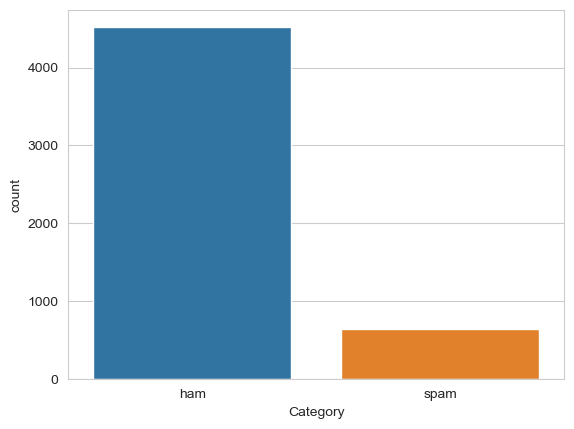

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correct column name from 'spam' to 'Category'
sns.countplot(x='Category', data=df_orig)
plt.show()


In [154]:
df['target'] = [1 if x=='spam' else 0 for  x in df.Category]
df.drop('Category', axis=1, inplace=True)
df.columns = ['message','target']
df.drop_duplicates(subset=['message'], keep='first', inplace=True)
df_spam = df[df.target==1]
df_ham = df[df.target==0]


In [155]:
ham_msg = df_ham.sample(n=len(df_spam),random_state=42)

Text(0.5, 0, 'Message types')

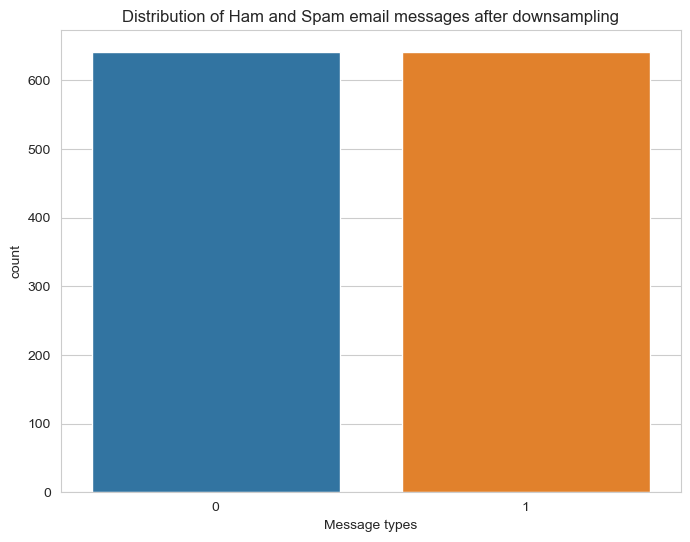

In [156]:
# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(df_spam)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='target')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [157]:
X= df.message
y= df.target

### EDA plots

In [158]:
df_orig['word_count'] = df_orig.Message.apply(lambda x: len(x.split(' ')))

In [159]:
df_orig.groupby('Category')['word_count'].agg(['count','mean','median'])

,count,mean,median
Category,,,
ham,4516,14.328388,11.0
spam,641,23.659906,25.0


In [160]:
df_orig.sample(10)

,Category,Message,word_count
621,ham,Dear we got &lt;#&gt; dollars hi hi,9
2851,ham,She's fine. Good to hear from you. How are you my dear? Happy new year oh.,16
4661,ham,You call him and tell now infront of them. Call him now.,12
5422,ham,Ok k..sry i knw 2 siva..tats y i askd..,9
793,ham,Y?WHERE U AT DOGBREATH? ITS JUST SOUNDING LIKE JAN C THATS AL!!!!!!!!!,12
2310,ham,"I have 2 sleeping bags, 1 blanket and paper and phone details. Anything else?",15
760,ham,"Call me when you/carlos is/are here, my phone's vibrate is acting up and I might not hear texts",18
2956,ham,Id have to check but there's only like 1 bowls worth left,12
4631,ham,Everybody had fun this evening. Miss you.,7
3566,ham,"We know TAJ MAHAL as symbol of love. But the other lesser known facts 1. Mumtaz was Shahjahan's 4th wife, out of his 7 wifes. 2. Shahjahan killed Mumtaz's husband to marry her. 3. Mumtaz died in her &lt;#&gt; th delivery. 4. He then married Mumtaz's sister. Question arises where the Hell is the LOVE?:-| -The Great Hari-",59


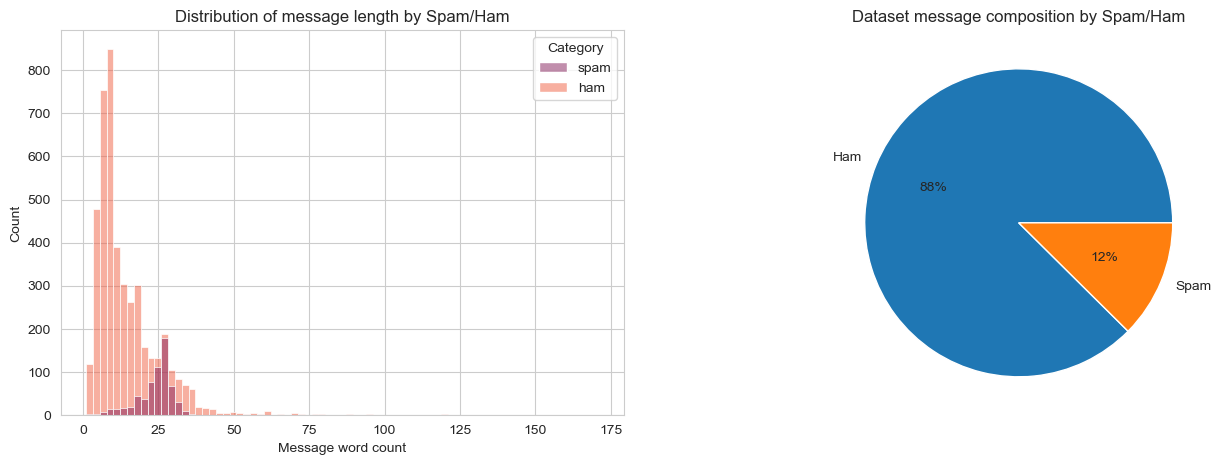

In [161]:
1# Plot message length by spam/ham

df_orig['Category'] = pd.Categorical(df_orig['Category'], ['spam','ham'])
sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
sns.histplot(data=df_orig, 
             x="word_count",
             hue="Category",
             palette='rocket',
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')
colors = sns.color_palette('rocket')

ax[1].pie(df_orig.Category.value_counts(normalize=True), labels = ['Ham','Spam'], autopct='%0.f%%')
ax[1].set_title('Dataset message composition by Spam/Ham')
#plt.savefig('images/eda.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [162]:
df_orig.sort_values(by='word_count', ascending=True)

,Category,Message,word_count
2508,ham,Yup...,1
1925,ham,Ok,1
3094,ham,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323,1
783,ham,Beerage?,1
4642,ham,Havent.,1
...,...,...,...
2434,ham,"Indians r poor but India is not a poor country. Says one of the swiss bank directors. He says that "" &lt;#&gt; lac crore"" of Indian money is deposited in swiss banks which can be used for 'taxless' budget for &lt;#&gt; yrs. Can give &lt;#&gt; crore jobs to all Indians. From any village to Delhi 4 lane roads. Forever free power suply to more than &lt;#&gt; social projects. Every citizen can get monthly &lt;#&gt; /- for &lt;#&gt; yrs. No need of World Bank &amp; IMF loan. Think how our money is blocked by rich politicians. We have full rights against corrupt politicians. Itna forward karo ki pura INDIA padhe.g.m.""",119
1579,ham,How to Make a girl Happy? It's not at all difficult to make girls happy. U only need to be... 1. A friend 2. Companion 3. Lover 4. Chef . . . &lt;#&gt; . Good listener &lt;#&gt; . Organizer &lt;#&gt; . Good boyfriend &lt;#&gt; . Very clean &lt;#&gt; . Sympathetic &lt;#&gt; . Athletic &lt;#&gt; . Warm . . . &lt;#&gt; . Courageous &lt;#&gt; . Determined &lt;#&gt; . True &lt;#&gt; . Dependable &lt;#&gt; . Intelligent . . . &lt;#&gt; . Psychologist &lt;#&gt; . Pest exterminator &lt;#&gt; . Psychiatrist &lt;#&gt; . Healer . . &lt;#&gt; . Stylist &lt;#&gt; . Driver . . Aaniye pudunga venaam..,121
2158,ham,"Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my Kids . I went to work. Even my Colleagues did not wish. As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there. She said,'' do u mind if I go into the bedroom for a minute ? '' ''OK'', I sed in a sexy mood. She came out 5 minuts latr wid a cake...n My Wife, My Parents, My Kidz, My Friends n My Colleagues. All screaming.. SURPRISE !! and I was waiting on the sofa.. ... ..... ' NAKED...!",125
1863,ham,"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.",162


In [163]:
balanced_data['message'] = balanced_data['message'].str.replace('Subject', '')
balanced_data.head(15)


,message,target
0,"Sorry, I can't help you on this.",0
1,"How's my loverboy doing ? What does he do that keeps him from coming to his Queen, hmmm ? Doesn't he ache to speak to me ? Miss me desparately ?",0
2,Sitting in mu waiting for everyone to get out of my suite so I can take a shower,0
3,Sure! I am driving but will reach my destination soon.,0
4,"Sorry, went to bed early, nightnight",0
5,I need to come home and give you some good lovin...,0
6,Yeah whatever lol,0
7,"Yes, my reg is Ciao!",0
8,Im just wondering what your doing right now?,0
9,"Come around &lt;DECIMAL&gt; pm vikky..i'm otside nw, il come by tht time",0


In [164]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

# sort words by frequency
def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [165]:

stop = stopwords.words('english')

# Series text column
tvec = TfidfVectorizer(stop_words = stop,
                       ngram_range = (1, 2),
                       max_features = 1000,
                       token_pattern = '[A-Za-z0-9]+(?=\\s+)',
                        )

# Fit vectorizer on text data
tvec.fit(df.message)

# Transform data
tvec_mat = tvec.transform(df.message)

# words occuring
words = tvec.get_feature_names_out()

# count word appearances
csum= word_counter(tvec_mat)

In [166]:
# sort words by frequency
df_word_frequency = pd.DataFrame(word_frequency_sorter(
    words, csum), columns=["word", "frequency_series"])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.index.name = None
df_word_frequency.head(20)


,frequency_series
u,187.755719
call,109.487576
get,108.333458
2,91.910420
ur,81.290887
got,78.853555
like,78.550733
come,77.469296
go,74.703036
know,68.392965


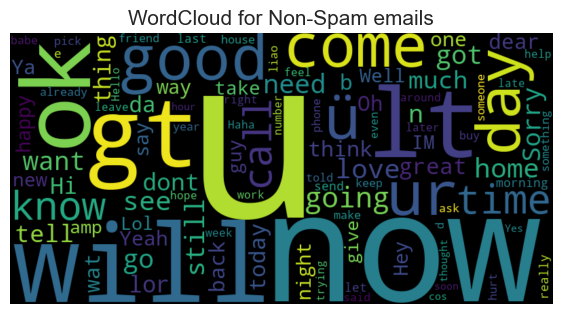

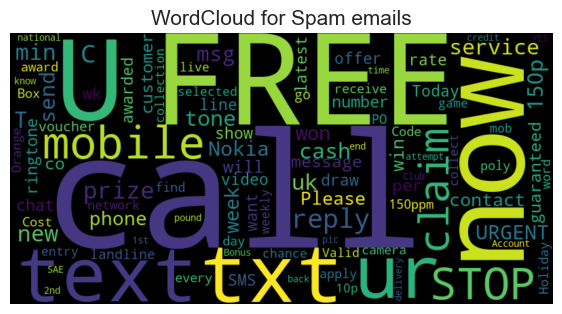

In [167]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['message'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['target'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['target'] == 1], typ='Spam')


## Model Building

In [168]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

In [169]:
SEQUENCE_LENGTH = 50 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

In [170]:
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

# Assuming X is a numpy array of text data
X = X.tolist()  # Convert numpy array to list of strings

# Initialize the Tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(X)

# Convert the text data to sequences of integers
X = tokenizer.texts_to_sequences(X)

# Save the word index for later use
word_index = tokenizer.word_index

# Define the sequence length and pad the sequences
SEQUENCE_LENGTH = 50  # the length of all sequences (number of words per sample)
X = pad_sequences(sequences=X, 
                  maxlen=SEQUENCE_LENGTH, 
                  padding='pre', 
                  truncating='post')

# Now you can proceed with splitting the data, model building, etc.


In [171]:
# split and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=5)
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (3867, 50)
X_test.shape: (1290, 50)
y_train.shape: (3867,)
y_test.shape: (1290,)


In [172]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
# Adding the embedding layer
model.add(Embedding(input_dim=len(word_index) + 1,  # vocabulary size
                    output_dim=EMBEDDING_SIZE,     # output dimension
                    input_length=SEQUENCE_LENGTH)) # input sequence length

# Adding an LSTM layer
model.add(LSTM(units=100, return_sequences=False)) # 'units' are the dimensionality of the output space

# Adding a dropout layer for regularization
model.add(Dropout(0.5))

# Adding a Dense output layer
model.add(Dense(1, activation='sigmoid')) # Use 'sigmoid' for binary classification



In [173]:
model.compile(optimizer='adam',                  # Optimizer
              loss='binary_crossentropy',        # Loss function for binary classification
              metrics=['accuracy'])              # List of metrics to monitor


In [174]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           900500    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 981,001
Trainable params: 981,001
Non-trainable params: 0
_________________________________________________________________


In [175]:
history = model.fit(X_train, y_train,                          # Training data
                    batch_size=BATCH_SIZE,                     # Batch size
                    epochs=EPOCHS,                             # Number of epochs
                    verbose=1,                                 # Verbosity mode
                    validation_data=(X_test, y_test))          # Validation data


Epoch 1/20
61/61 [==============================] - 7s 69ms/step - loss: 0.2901 - accuracy: 0.8999 - val_loss: 0.1012 - val_accuracy: 0.9822
Epoch 2/20
61/61 [==============================] - 6s 93ms/step - loss: 0.0501 - accuracy: 0.9868 - val_loss: 0.0529 - val_accuracy: 0.9845
Epoch 3/20
61/61 [==============================] - 6s 98ms/step - loss: 0.0209 - accuracy: 0.9953 - val_loss: 0.0846 - val_accuracy: 0.9767
Epoch 4/20
61/61 [==============================] - 6s 103ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0743 - val_accuracy: 0.9822
Epoch 5/20
61/61 [==============================] - 6s 93ms/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.0616 - val_accuracy: 0.9876
Epoch 6/20
61/61 [==============================] - 5s 86ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0696 - val_accuracy: 0.9860
Epoch 7/20
61/61 [==============================] - 5s 79ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0770 - val_accuracy: 0.9845
Epoch 8/20
6

In [176]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


41/41 [==============================] - 1s 12ms/step - loss: 0.1152 - accuracy: 0.9837
Test Score: 0.11516182124614716
Test Accuracy: 0.9837209582328796
